# WEEK 3
### Table of contents

<ul>
    <li>
        <a href="#1">Preparing DataSet</a>
    </li>
    <li>
        <a href="#2">Data Visualization</a>
    </li>
    <li>
        <a href="#3">Model</a>
    </li>
    
</ul>    

In [123]:
from os.path import dirname, join as pjoin
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import scipy.io 
import h5py
%matplotlib inline

window = 240
latency = 0 
channel = 11 - 1 #cz
channels = list(range(64))

<a id='1'></a>
## Preparing DataSet

In [124]:
train = scipy.io.loadmat('../Data/Subject_A_Train.mat') 
test = scipy.io.loadmat('../Data/Subject_A_Test.mat')
test_results = list(open('../Data/true_labels_a.txt','r').read())
train.keys()

dict_keys(['__header__', '__version__', '__globals__', 'Signal', 'TargetChar', 'Flashing', 'StimulusCode', 'StimulusType'])

In [125]:
Characters = np.array(list(train['TargetChar'][0]))

In [126]:
matrix = np.array([['A','B','C','D','E','F'],['G','H','I','J','K','L'],['M','N','O','P','Q','R'],['S','T','U','V','W','X'],['Y','Z','1','2','3','4'],['5','6','7','8','9','_']])
matrix[0][5]

'F'

In [127]:
responses = np.array([])

for epoch in range(train['Signal'].shape[0]):
    for i in range(1,train['Signal'].shape[1]):
        if(train['Flashing'][epoch][i] < 0.5 and train['Flashing'][epoch][i-1] > 0.5):
            sample = np.array(train['Signal'][epoch][i-24:i+window-24,channel])
            rowcol = train['StimulusCode'][epoch][i-1]
            temp = {'Epoch':epoch+1,'Character':Characters[epoch],'rowcol':rowcol,'Sample':sample,'Isp300':train['StimulusType'][epoch][i-1]}
            responses = np.append(responses,temp)

In [128]:
def character_in_Row_Col(c,n):
    if n not in (range(1,13)):
        return 0.0
    if n<=6:
        if(c in matrix[:,n-1]):
            return 1.0
        else:
            return 0.0
    else:
        if(c in matrix[n-7]):
            return 1.0
        else:
            return 0.0

In [129]:
test_responses = np.array([])
for epoch in range(len(test_results)):
    for i in range(1,test['Signal'].shape[1]):
        if(test['Flashing'][epoch][i] < 0.5 and test['Flashing'][epoch][i-1] > 0.5):
            sample = np.array(test['Signal'][epoch][i-24:i+window-24,channel])
            rowcol = test['StimulusCode'][epoch][i-1]
            temp = {'Epoch':epoch+1,'Character':test_results[epoch],'rowcol':rowcol,'Sample':sample,'Isp300':character_in_Row_Col(test_results[epoch],int(rowcol))}
            test_responses = np.append(test_responses,temp)

In [130]:
df = pd.DataFrame(list(responses),columns =['Epoch','Character', 'rowcol','Sample','Isp300'])
df.head()

,Epoch,Character,rowcol,Sample,Isp300
0,1,E,12.0,"[-5.1392, -1.54176, 1.02784, -2.5696, -12.0771...",0.0
1,1,E,11.0,"[-3.08352, 4.11136, 7.45184, 4.62528, 0.51392,...",0.0
2,1,E,3.0,"[1.2848, 2.31264, 3.59744, 7.45184, 12.33408, ...",0.0
3,1,E,10.0,"[-7.19488, 1.79872, -2.31264, -11.5632, -9.764...",0.0
4,1,E,9.0,"[-29.29344, -23.1264, -21.8416, -21.58464, -13...",0.0


In [131]:
df_test = pd.DataFrame(list(test_responses),columns =['Epoch','Character', 'rowcol','Sample','Isp300'])
df_test['Epoch']=df_test['Epoch'] + 85
df_test.head()

,Epoch,Character,rowcol,Sample,Isp300
0,86,W,8.0,"[-21.8416, -24.4112, -26.20992, -25.696, -23.1...",0.0
1,86,W,4.0,"[-28.2656, -25.95296, -28.00864, -33.66176, -3...",0.0
2,86,W,6.0,"[-10.53536, -12.33408, -14.64672, -14.90368, -...",0.0
3,86,W,2.0,"[-18.50112, -18.24416, -14.1328, -13.87584, -1...",0.0
4,86,W,7.0,"[-14.1328, -19.52896, -24.92512, -23.38336, -1...",0.0


In [132]:
df_all = pd.concat([df,df_test]).reset_index()

<a id='2'></a>
## Data Visualization

In [133]:
def graphDrawer(df):
    average_p300 = df[df['Isp300']==1]['Sample'].mean()
    average_non_p300 = df[df['Isp300']==0]['Sample'].mean()
    x_axis = np.array(range(window))/240
    plt.figure(figsize=(12, 6), dpi=80)
    plt.plot(x_axis,average_p300,color='#188038',label='P300')
    plt.plot(x_axis,average_non_p300,color='#A1282C',label='Non-P300')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.title('P300 VS Non-P300')
    plt.legend()
    plt.tight_layout()
    plt.show()

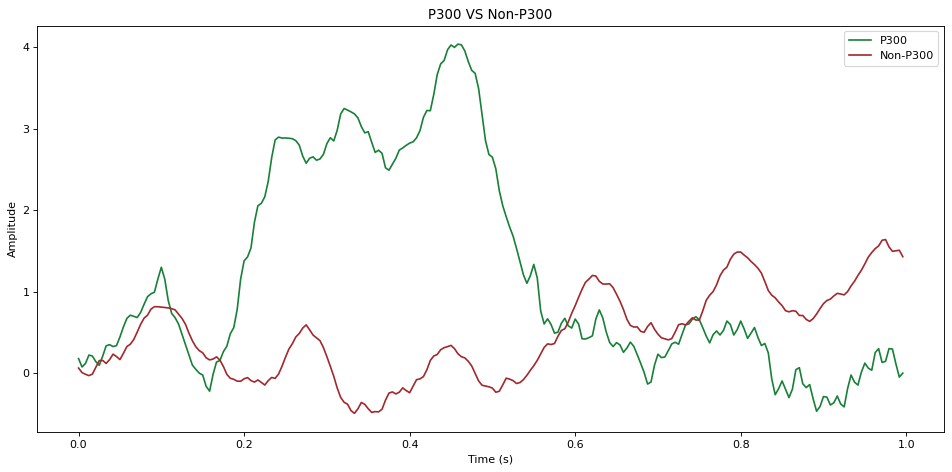

In [134]:
graphDrawer(df)

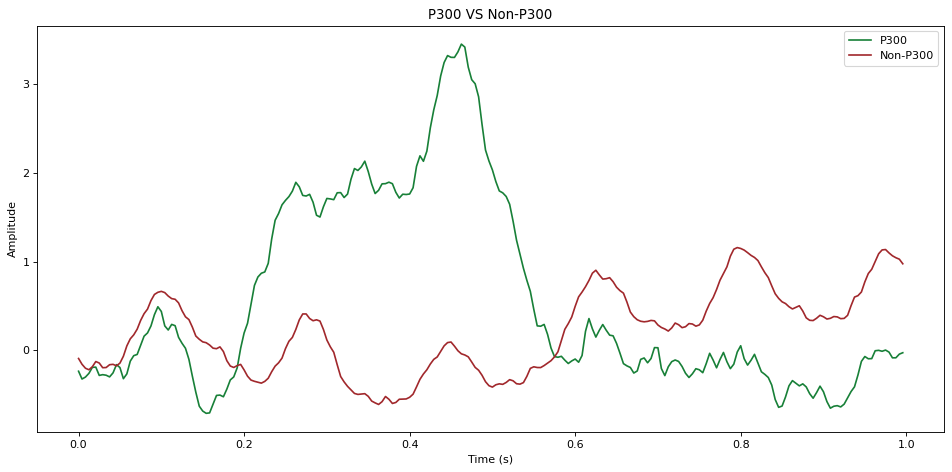

In [135]:
graphDrawer(df_test)

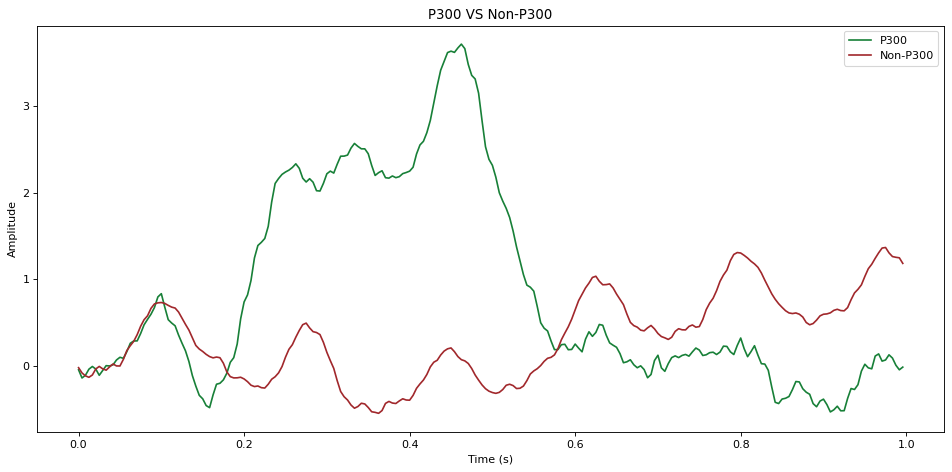

In [136]:
graphDrawer(df_all)

In [137]:
df_all = pd.concat([df_all,pd.DataFrame(list(map(np.ravel, (list(df_all['Sample'])))))],axis=1).drop('index',axis=1)
df = pd.concat([df,pd.DataFrame(list(map(np.ravel, (list(df['Sample'])))))],axis=1)
df_test = pd.concat([df_test,pd.DataFrame(list(map(np.ravel, (list(df_test['Sample'])))))],axis=1)

,Epoch,Character,rowcol,Sample,Isp300,0,1,2,3,4,...,230,231,232,233,234,235,236,237,238,239
0,1,E,12.0,"[-5.1392, -1.54176, 1.02784, -2.5696, -12.0771...",0.0,-5.139200,-1.541760,1.027840,-2.569600,-12.07712,...,-1.541760,-0.513920,4.88224,3.597440,-0.770880,-1.541760,-1.027840,-5.653120,-11.820160,-14.389760
1,1,E,11.0,"[-3.08352, 4.11136, 7.45184, 4.62528, 0.51392,...",0.0,-3.083520,4.111360,7.451840,4.625280,0.51392,...,9.764480,-0.256960,-0.77088,0.000000,-0.770880,-1.284800,-1.284800,6.167040,15.674560,9.507520
2,1,E,3.0,"[1.2848, 2.31264, 3.59744, 7.45184, 12.33408, ...",0.0,1.284800,2.312640,3.597440,7.451840,12.33408,...,-8.479680,-12.591040,-13.36192,-4.882240,-8.993600,-15.417600,-14.903680,-13.361920,-11.563200,-8.993600
3,1,E,10.0,"[-7.19488, 1.79872, -2.31264, -11.5632, -9.764...",0.0,-7.194880,1.798720,-2.312640,-11.563200,-9.76448,...,-4.625280,-6.424000,-0.51392,-0.256960,-4.111360,-4.882240,-4.111360,-8.993600,-11.563200,-10.278400
4,1,E,9.0,"[-29.29344, -23.1264, -21.8416, -21.58464, -13...",0.0,-29.293440,-23.126400,-21.841600,-21.584641,-13.61888,...,3.597440,5.653120,6.93792,2.826560,-0.513920,0.770880,-0.770880,-2.826560,-0.770880,3.083520
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33295,185,U,4.0,"[-2.5696, -1.2848, -2.82656, -4.36832, -3.8544...",0.0,-2.569600,-1.284800,-2.826560,-4.368320,-3.85440,...,2.569600,-1.284800,0.25696,4.882240,2.312640,-1.541760,0.256960,1.798720,-1.541760,-3.854400
33296,185,U,10.0,"[-16.18848, -19.52896, -15.16064, -10.2784, -1...",1.0,-16.188480,-19.528959,-15.160640,-10.278400,-10.27840,...,-11.820160,-4.882240,-2.31264,-6.167040,-6.680960,-5.396160,-6.680960,-8.479680,-8.736640,-7.965760
33297,185,U,3.0,"[-16.7024, -15.16064, -17.21632, -17.9872, -14...",1.0,-16.702400,-15.160640,-17.216320,-17.987200,-14.13280,...,33.661758,34.689602,34.43264,35.717442,36.488319,37.259201,41.113602,46.509762,52.419842,60.128639
33298,185,U,8.0,"[-12.59104, -18.50112, -19.01504, -15.67456, -...",0.0,-12.591040,-18.501120,-19.015039,-15.674560,-17.21632,...,26.723841,22.098560,14.90368,8.736640,5.653120,5.910080,4.111360,3.597440,6.937920,10.278400


In [139]:
df_all = df_all.groupby(['Epoch','Character','rowcol','Isp300']).mean().reset_index()

,Epoch,Character,rowcol,Isp300,0,1,2,3,4,5,...,230,231,232,233,234,235,236,237,238,239
0,1,E,1.0,0.0,-0.154176,0.736619,-0.890795,-2.244117,-0.308352,0.770880,...,1.815851,0.805141,2.569600e+00,4.111360,2.929344,0.565312,-1.199147,0.513920,0.137045,-1.661675
1,1,E,2.0,0.0,-0.291221,-0.548181,0.702357,0.017131,-1.113493,0.582443,...,9.370475,7.486102,7.948629e+00,8.616725,7.657408,5.396160,4.162752,4.762325,5.241984,5.173461
2,1,E,3.0,0.0,-0.222699,-1.952896,-1.370453,-0.496789,1.695936,3.237696,...,-0.411136,-1.010709,-7.947286e-08,0.805141,-1.490368,-2.346901,-1.267669,0.376875,-0.051392,-1.096363
3,1,E,4.0,0.0,-1.250539,-0.788011,-0.496789,-2.912213,-4.710933,-4.882240,...,2.912213,3.837269,4.094229e+00,4.642411,4.505365,1.319061,0.308352,0.479659,-0.291221,-0.017131
4,1,E,5.0,1.0,-4.573888,-2.860821,-1.798720,-3.700224,-3.957184,-3.665963,...,5.327637,5.207723,4.077099e+00,3.237696,5.190592,8.085674,6.698091,3.237696,2.895083,5.344768
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2215,185,U,8.0,0.0,2.004288,1.079232,0.599573,1.233408,1.850112,1.832981,...,2.603861,2.689515,3.871531e+00,4.265536,2.980736,1.935765,2.158464,1.867243,0.685227,0.805141
2216,185,U,9.0,0.0,4.334059,3.083520,3.511787,3.803008,2.603861,1.952896,...,0.154176,1.182016,5.995733e-01,-0.154176,-0.102784,-0.633835,-1.850112,-2.792299,-1.490368,-0.616704
2217,185,U,10.0,1.0,1.370453,0.102784,0.959317,1.267669,0.668096,0.942187,...,-2.775168,-0.873664,-8.907945e-01,-0.565312,1.421845,2.758037,1.713067,1.182016,2.963605,3.546048
2218,185,U,11.0,0.0,8.274112,9.695957,10.295530,9.216299,8.496811,7.914368,...,1.319061,0.770880,-8.736640e-01,-1.832981,-2.278379,-2.758037,-2.449685,-1.644544,-0.976448,-0.788011


In [141]:
df_test = df_test.groupby(['Epoch','Character','rowcol','Isp300']).mean().reset_index()


,Epoch,Character,rowcol,Isp300,0,1,2,3,4,5,...,230,231,232,233,234,235,236,237,238,239
0,86,W,1.0,0.0,4.573888,3.374741,3.391872,4.351189,4.710933,2.758037,...,2.552469,2.535339,2.535339,2.518208,1.558891,1.147755,1.301931,1.781589,2.141333,2.432555
1,86,W,2.0,0.0,1.627413,0.548181,0.222699,-0.274091,-0.616704,0.102784,...,9.815872,10.278400,11.426155,10.586752,8.085674,7.349056,8.102805,8.445418,7.760192,6.167040
2,86,W,3.0,0.0,-1.832981,-2.569600,-3.014997,-1.524629,0.342613,-0.034261,...,1.507499,2.175595,2.706645,1.353323,0.839403,0.548181,0.017130,-0.394005,-0.017131,1.918635
3,86,W,4.0,0.0,-2.415424,-0.788011,-0.531051,-2.586730,-3.974315,-3.528917,...,-1.027840,-0.788011,0.017131,0.753749,1.062101,0.770880,1.182016,2.398293,3.134912,2.449685
4,86,W,5.0,1.0,-1.147754,-1.062101,-1.216277,-1.336192,-0.736619,-0.445397,...,-1.182016,-1.164885,-2.038549,-2.364032,-2.175595,-2.295509,-1.627413,-0.154176,0.017131,-0.479659
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1195,185,U,8.0,0.0,2.004288,1.079232,0.599573,1.233408,1.850112,1.832981,...,2.603861,2.689515,3.871531,4.265536,2.980736,1.935765,2.158464,1.867243,0.685227,0.805141
1196,185,U,9.0,0.0,4.334059,3.083520,3.511787,3.803008,2.603861,1.952896,...,0.154176,1.182016,0.599573,-0.154176,-0.102784,-0.633835,-1.850112,-2.792299,-1.490368,-0.616704
1197,185,U,10.0,1.0,1.370453,0.102784,0.959317,1.267669,0.668096,0.942187,...,-2.775168,-0.873664,-0.890794,-0.565312,1.421845,2.758037,1.713067,1.182016,2.963605,3.546048
1198,185,U,11.0,0.0,8.274112,9.695957,10.295530,9.216299,8.496811,7.914368,...,1.319061,0.770880,-0.873664,-1.832981,-2.278379,-2.758037,-2.449685,-1.644544,-0.976448,-0.788011


In [142]:
df = df.groupby(['Epoch','Character','rowcol','Isp300']).mean().reset_index()


,Epoch,Character,rowcol,Isp300,0,1,2,3,4,5,...,230,231,232,233,234,235,236,237,238,239
0,1,E,1.0,0.0,-0.154176,0.736619,-0.890795,-2.244117,-0.308352,0.770880,...,1.815851,0.805141,2.569600e+00,4.111360,2.929344,0.565312,-1.199147,0.513920,0.137045,-1.661675
1,1,E,2.0,0.0,-0.291221,-0.548181,0.702357,0.017131,-1.113493,0.582443,...,9.370475,7.486102,7.948629e+00,8.616725,7.657408,5.396160,4.162752,4.762325,5.241984,5.173461
2,1,E,3.0,0.0,-0.222699,-1.952896,-1.370453,-0.496789,1.695936,3.237696,...,-0.411136,-1.010709,-7.947286e-08,0.805141,-1.490368,-2.346901,-1.267669,0.376875,-0.051392,-1.096363
3,1,E,4.0,0.0,-1.250539,-0.788011,-0.496789,-2.912213,-4.710933,-4.882240,...,2.912213,3.837269,4.094229e+00,4.642411,4.505365,1.319061,0.308352,0.479659,-0.291221,-0.017131
4,1,E,5.0,1.0,-4.573888,-2.860821,-1.798720,-3.700224,-3.957184,-3.665963,...,5.327637,5.207723,4.077099e+00,3.237696,5.190592,8.085674,6.698091,3.237696,2.895083,5.344768
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1015,85,I,8.0,1.0,2.226987,2.483947,2.364032,2.226987,2.535339,2.758037,...,5.379029,4.591019,3.957184e+00,3.871531,3.460395,2.792299,3.186304,4.505365,4.985024,4.453973
1016,85,I,9.0,0.0,2.655253,3.717355,3.768747,2.175595,1.044971,1.182016,...,1.387584,0.856533,4.111359e-01,1.935765,2.877952,1.747328,1.079232,1.832981,2.312640,1.576021
1017,85,I,10.0,0.0,3.083520,2.261248,1.387584,2.226987,3.237696,2.346901,...,0.034261,0.890795,2.004288e+00,0.925056,-0.565312,-0.171307,-0.068523,-1.661675,-3.186304,-3.203435
1018,85,I,11.0,0.0,2.124203,1.576021,2.278379,2.381163,1.730197,1.832981,...,-3.186304,-2.740907,-2.346901e+00,-1.593152,-0.907925,-0.753749,-0.890795,-0.205568,1.096363,2.209856


In [143]:
p300_df = df[df['Isp300'] == 1.0].reset_index()
non_p300_df = df[df['Isp300'] == 0.0].reset_index()

In [144]:
df.shape

(1020, 244)

In [145]:
p300_df.shape

(170, 245)

In [146]:
non_p300_df.shape

(850, 245)

In [147]:
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
from sklearn.utils import shuffle
from sklearn import metrics

In [170]:
def characters_accuracy( clf, df ):
    res = np.array([])
    for epoch in range(df.min()["Epoch"],df.max()["Epoch"]+1):
        df_epoch = df[df['Epoch']==epoch].reset_index(drop=True)
        if(df_epoch.size == 0):
            continue
        X,_ = prepare_X_y(df_epoch)   
        df_epoch = df_epoch[["Epoch","Character","rowcol","Isp300"]]
        df_epoch['Score'] = clf.decision_function(X)
        row = df_epoch.iloc[6:]['Score'].idxmax()
        col = df_epoch.iloc[:6]['Score'].idxmax()
        predicted_row = df_epoch.iloc[row]['rowcol']
        predicted_col = df_epoch.iloc[col]['rowcol']
        predicted_char = matrix[row-6][col]
        target_char = df_epoch['Character'][0]
        res = np.append(res,{'Epoch':epoch,'Target_Character':target_char,'Predicted_Character':predicted_char,'Predicted_Row':predicted_row,'Predicted_Col':predicted_col,'Same':(target_char==predicted_char)})
    return pd.DataFrame(list(res),columns=['Epoch','Target_Character','Predicted_Character','Predicted_Row','Predicted_Col','Same'])

In [149]:
def prepare_X_y(temp_df):
    X=temp_df.drop(columns = ['Epoch','Character','rowcol','Isp300'])
    y= temp_df['Isp300']
    return X,y

In [150]:
##Separating Target from Other Features :
X,y = prepare_X_y(df)
##Splitting Data set to train and test:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(X_train.head(20))
print(y_train.head(20))

           0          1          2          3          4          5    \
601   2.432555   3.169173   0.873664   0.993578   3.374742   3.888661   
227  -0.907925  -0.291221  -0.051392   0.034261   0.856533   0.856534   
873   0.342613  -0.993579   0.034261   1.147755   3.152043   4.094229   
359  25.850176  24.890858  24.291285  24.873728  25.319126  26.141397   
813   1.044971   0.805141   0.873664   2.072811   2.312640   1.062101   
177  -1.027840  -1.970027  -2.158464  -1.730197  -1.164885  -1.164885   
994   3.460395   3.511786   3.323349   3.854400   5.361898   5.978602   
756  -2.329771  -0.513920   0.017131  -1.713067  -4.573888  -4.608150   
493  -2.672384  -4.453973  -5.344768  -3.648832  -2.124203  -0.685227   
334  -6.989312  -5.875819  -5.241984  -6.029994  -6.475392  -5.019286   
892   2.963605   2.346901   2.689515   2.244117   1.850112   3.254827   
7    -2.415424  -6.029994  -5.704512  -2.346901  -0.736619  -1.627413   
155  -1.593152   0.308352   0.496789   0.137045   1

In [151]:

clf = svm.SVC(kernel='linear',probability=True)
##clf = GradientBoostingClassifier(n_estimators=10000)
clf.fit(X_train, y_train)

svc_score_train = clf.decision_function(X)
svc_score_test =clf.predict(X)


#y_pred=svc.predict(X_test)
list(zip(svc_score_train,svc_score_test))

[(-9.322896674733666, 0.0),
 (-9.298050004591456, 0.0),
 (-13.766634507077153, 0.0),
 (-0.6880716678492966, 0.0),
 (1.0000301818969923, 1.0),
 (4.5850557798309275, 1.0),
 (1.0005475859543402, 1.0),
 (-3.596783371429037, 0.0),
 (-17.80082766165088, 0.0),
 (-7.75353538925145, 0.0),
 (0.8072223109477115, 1.0),
 (-4.905443412501821, 0.0),
 (6.940020682196636, 1.0),
 (-1.1135226566081222, 0.0),
 (-3.7001490728540993, 0.0),
 (-6.361864505052576, 0.0),
 (-0.9999034579422923, 0.0),
 (-8.879321356858267, 0.0),
 (2.794031612206087, 1.0),
 (-9.372061817160724, 0.0),
 (-9.260527077308065, 0.0),
 (-7.91206203818458, 0.0),
 (-7.179228399323446, 0.0),
 (-4.048389126974879, 0.0),
 (-0.9994232686328068, 0.0),
 (-2.30614029478377, 0.0),
 (-14.53704994924583, 0.0),
 (-7.799608132956859, 0.0),
 (3.586403549736847, 1.0),
 (-9.616844503316905, 0.0),
 (0.618357467491709, 1.0),
 (-1.7115438396590186, 0.0),
 (-11.14429262704908, 0.0),
 (-4.213937048053278, 0.0),
 (-8.740025672409299, 0.0),
 (-6.408703341202166

In [172]:
characters_accuracy(clf,df_test)

,Epoch,Target_Character,Predicted_Character,Predicted_Row,Predicted_Col,Same
0,86,W,W,10.0,5.0,True
1,87,Q,P,9.0,4.0,False
2,88,X,T,10.0,2.0,False
3,89,P,D,7.0,4.0,False
4,90,L,5,12.0,1.0,False
...,...,...,...,...,...,...
95,181,R,F,7.0,6.0,False
96,182,3,Q,9.0,5.0,False
97,183,M,R,9.0,6.0,False
98,184,R,F,7.0,6.0,False


In [ ]:
X,y = prepare_X_y(df[df['Isp300']==0])
clf.score(X, y)

In [ ]:
X,y = prepare_X_y(df_test)
y_pred=clf.predict(X)
clf.score(X, y)

AttributeError: 'SVC' object has no attribute 'decison_function'

In [254]:
df_balanced = pd.concat([df[df['Isp300']==1],df[df['Isp300']==0].sample(170,random_state = 42,ignore_index = True)],ignore_index = True)
df_balanced

,Epoch,Character,rowcol,Isp300,0,1,2,3,4,5,...,230,231,232,233,234,235,236,237,238,239
0,1,E,5.0,1.0,-4.573888,-2.860821,-1.798720,-3.700224,-3.957184,-3.665963,...,5.327637,5.207723,4.077099,3.237696,5.190592,8.085674,6.698091,3.237696,2.895083,5.344768
1,1,E,7.0,1.0,-0.462528,-1.199147,-1.593152,0.753749,2.346901,1.490368,...,7.811584,7.331925,6.149909,4.676672,3.426133,3.271957,4.710933,5.567467,5.344768,3.460395
2,2,A,1.0,1.0,4.453973,3.477525,2.295509,1.781589,1.473237,0.770880,...,-5.721642,-5.344768,-4.522496,-3.854400,-3.254827,-1.627413,-0.890795,-0.616704,-0.719488,-1.044971
3,2,A,7.0,1.0,1.987157,0.822272,0.119915,0.616704,1.713067,2.586731,...,-0.788010,0.548181,0.856533,-0.034261,0.342613,0.805141,0.394005,0.034261,0.051392,0.325483
4,3,E,5.0,1.0,-1.096363,-2.912213,-2.192725,-0.102784,-0.548182,-1.798720,...,-4.094230,-1.096363,0.017131,-1.901504,-2.021419,1.353323,3.391872,1.096363,0.342613,3.340480
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
335,30,H,9.0,0.0,5.995733,5.430421,5.498943,5.464683,5.550336,5.790165,...,11.888682,11.494678,10.158485,11.820160,13.961493,12.385471,12.830870,14.612458,14.064277,12.059989
336,16,O,7.0,0.0,-3.837269,-2.723776,-2.312640,-4.231275,-4.899371,-3.014997,...,10.072832,8.171328,7.554624,8.942208,8.890816,8.239851,7.982891,8.650987,9.164907,7.948629
337,33,M,8.0,0.0,-2.209856,-2.038549,-1.935765,-2.638123,-3.528917,-3.032128,...,-0.907925,-1.610283,-2.689515,-2.552469,-1.764459,-1.747328,-2.226987,-2.329771,-2.672384,-3.546048
338,11,8,2.0,0.0,-14.595328,-9.678826,-5.464683,-1.404715,-0.188438,1.147754,...,30.800938,29.858751,30.920855,32.616791,30.920853,28.796650,32.000088,33.661758,26.706711,16.805183


In [255]:
X,y = prepare_X_y(shuffle(df_balanced).reset_index(drop=True))
clf = svm.SVC(kernel='linear')
##clf = GradientBoostingClassifier(n_estimators=10000)
clf.fit(X, y)


X_test,y_test = prepare_X_y(df)
svc_score_train = clf.score(X_test, y_test) #Coefficient of determination
X_test,y_test = prepare_X_y(df_test)
svc_score_test =clf.score(X_test, y_test)
#y_pred=svc.predict(X_test)

print('train score: {}'.format(svc_score_train)) 
print('test score: {}'.format(svc_score_test))


train score: 0.8235294117647058
test score: 0.74


In [256]:
characters_accuracy(clf,df)

,Character,P300,Non_P300,Total
0,A,1.0,0.900000,0.916667
1,B,1.0,0.800000,0.833333
2,C,1.0,0.700000,0.750000
3,D,1.0,0.875000,0.895833
4,E,1.0,0.787500,0.822917
5,F,1.0,0.750000,0.791667
6,G,1.0,0.950000,0.958333
7,H,1.0,0.750000,0.791667
8,I,1.0,0.766667,0.805556
9,J,1.0,0.800000,0.833333


In [262]:
responses = np.array([])

for epoch in range(train['Signal'].shape[0]):
    for i in range(1,train['Signal'].shape[1]):
        if(train['Flashing'][epoch][i] < 0.5 and train['Flashing'][epoch][i-1] > 0.5):
            
            sample = np.array([])
            
            for ch in channels:
                sample = np.append(sample,train['Signal'][epoch][i-24:i+window-24,ch])
            rowcol = train['StimulusCode'][epoch][i-1]
            temp = {'Epoch':epoch+1,'Character':Characters[epoch],'rowcol':rowcol,'Sample':sample,'Isp300':train['StimulusType'][epoch][i-1]}
            responses = np.append(responses,temp)

In [263]:
test_responses = np.array([])
for epoch in range(len(test_results)):
    for i in range(1,test['Signal'].shape[1]):
        if(test['Flashing'][epoch][i] < 0.5 and test['Flashing'][epoch][i-1] > 0.5):
            sample = np.array([])
            for ch in channels:
                sample = np.append(sample,test['Signal'][epoch][i-24:i+window-24,channel])
            rowcol = test['StimulusCode'][epoch][i-1]
            temp = {'Epoch':epoch+1,'Character':test_results[epoch],'rowcol':rowcol,'Sample':sample,'Isp300':character_in_Row_Col(test_results[epoch],int(rowcol))}
            test_responses = np.append(test_responses,temp)

In [283]:
df_extended = pd.DataFrame(list(responses),columns =['Epoch','Character', 'rowcol','Sample','Isp300'])
df_extended.head()

,Epoch,Character,rowcol,Sample,Isp300
0,1,E,12.0,"[0.08084999769926071, -2.2476298809051514, 7.5...",0.0
1,1,E,11.0,"[4.737810134887695, 12.499409675598145, 12.758...",0.0
2,1,E,3.0,"[2.1506099700927734, 7.066289901733398, 11.205...",0.0
3,1,E,10.0,"[2.6680500507354736, 8.87732982635498, 14.8278...",0.0
4,1,E,9.0,"[-18.029550552368164, -14.924909591674805, -8....",0.0


In [284]:
df_extended = pd.concat([df_extended,pd.DataFrame(list(map(np.ravel, (list(df_extended['Sample'])))))],axis=1)
df_extended

,Epoch,Character,rowcol,Sample,Isp300,0,1,2,3,4,...,15350,15351,15352,15353,15354,15355,15356,15357,15358,15359
0,1,E,12.0,"[0.08084999769926071, -2.2476298809051514, 7.5...",0.0,0.080850,-2.24763,7.583730,0.080850,-7.680750,...,-5.69374,-2.648620,-2.141100,-6.201260,-6.96254,-1.88734,-3.40990,-8.48510,-10.00766,-6.70878
1,1,E,11.0,"[4.737810134887695, 12.499409675598145, 12.758...",0.0,4.737810,12.49941,12.758130,0.080850,-6.128430,...,1.91906,0.142740,1.919060,3.187860,1.66530,-0.61854,-0.36478,5.21794,5.97922,-0.87230
2,1,E,3.0,"[2.1506099700927734, 7.066289901733398, 11.205...",0.0,2.150610,7.06629,11.205810,3.185490,-4.834830,...,-14.06782,-13.306540,-10.007660,-12.037740,-14.06782,-13.05278,-12.54526,-14.06782,-13.05278,-11.27646
3,1,E,10.0,"[2.6680500507354736, 8.87732982635498, 14.8278...",0.0,2.668050,8.87733,14.827890,4.996530,-6.645870,...,-8.73886,-8.485100,-6.962540,-7.977580,-8.48510,-6.20126,-3.66366,-4.17118,-6.45502,-5.43998
4,1,E,9.0,"[-18.029550552368164, -14.924909591674805, -8....",0.0,-18.029551,-14.92491,-8.198190,-11.561550,-13.113870,...,-7.47006,-4.171180,-5.947500,-9.753900,-8.48510,-6.45502,-8.73886,-10.51518,-8.48510,-9.24638
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15295,85,I,2.0,"[-11.56155014038086, -12.85515022277832, -13.3...",0.0,-11.561550,-12.85515,-13.372590,-14.924910,-18.288271,...,-5.69374,-6.708780,-6.708780,-1.887340,2.17282,0.14274,-3.66366,-3.40990,-5.18622,-9.50014
15296,85,I,3.0,"[-14.407469749450684, -15.183629989624023, -19...",1.0,-14.407470,-15.18363,-19.323151,-20.099310,-16.477230,...,0.65026,3.441620,1.411540,-1.887340,1.15778,6.23298,4.20290,-2.14110,-1.63358,3.44162
15297,85,I,12.0,"[-12.07898998260498, -12.596429824829102, -10....",0.0,-12.078990,-12.59643,-10.009230,-10.785390,-14.924910,...,27.04130,35.415379,36.176659,31.355221,17.65218,2.17282,-2.90238,0.14274,1.15778,-2.14110
15298,85,I,8.0,"[-14.407469749450684, -13.63131046295166, -15....",1.0,-14.407470,-13.63131,-15.442350,-13.113870,-6.904590,...,-5.18622,4.964180,10.800660,7.501780,5.72546,12.57698,16.12962,7.50178,1.91906,7.75554


In [285]:
df_extended = df_extended.groupby(['Epoch','Character','rowcol','Isp300']).mean().reset_index()
df_extended

,Epoch,Character,rowcol,Isp300,0,1,2,3,4,5,...,15350,15351,15352,15353,15354,15355,15356,15357,15358,15359
0,1,E,1.0,0.0,-1.816430,0.546546,1.357202,1.305458,0.253330,-0.264110,...,-0.026433,-0.635457,0.498004,0.464169,-1.024556,-2.107265,-0.161772,0.667177,-1.024556,-1.633580
1,1,E,2.0,0.0,-1.212750,-0.195118,-0.471086,-2.678830,-4.231150,-1.540462,...,-2.005761,-3.088471,-2.242604,-1.565911,-2.597868,-3.139223,-1.735084,0.193492,1.123945,2.663423
2,1,E,3.0,0.0,-1.436974,-1.350734,0.270578,-0.522830,-0.764302,0.529298,...,-0.686209,-0.533953,0.091988,-0.483201,-0.939969,-0.500119,0.954772,2.138985,1.665300,1.157780
3,1,E,4.0,0.0,0.046354,0.788018,-1.609454,-2.661582,-4.334638,-4.110414,...,1.073193,2.967935,3.272447,2.545001,1.310036,1.242367,0.599508,-0.584705,0.159657,2.054399
4,1,E,5.0,1.0,-2.644334,-2.213134,-0.160622,-1.161006,-1.229998,-1.316238,...,0.362665,-0.026433,0.582591,2.341993,4.236735,4.608916,2.866431,1.445375,1.597631,1.749887
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1015,85,I,8.0,1.0,-5.645486,-6.076686,-6.369902,-6.594126,-5.990446,-5.197038,...,-2.107265,-1.921175,-1.464407,-1.667415,-2.174935,-1.735084,-0.855383,-1.227564,-2.225687,-2.614785
1016,85,I,9.0,0.0,-1.023022,-0.712558,-0.246862,-0.971278,-1.937166,-1.937166,...,2.934100,1.919060,2.663423,3.627711,2.511167,1.107028,1.749887,3.204777,2.866431,2.122068
1017,85,I,10.0,0.0,3.306226,3.495954,3.340722,4.203122,5.600210,4.962034,...,1.969812,3.644628,3.796884,2.866431,2.917183,3.830719,3.441620,1.479209,-0.026433,-0.449367
1018,85,I,11.0,0.0,0.098098,-0.229614,-0.298606,-1.264494,-2.023406,-1.178254,...,-1.582828,-1.870423,-1.870423,-1.616663,-1.396737,-1.295233,-0.432449,1.885225,3.526207,3.137108


In [286]:
df_extended_test = pd.DataFrame(list(test_responses),columns =['Epoch','Character', 'rowcol','Sample','Isp300'])
df_extended_test.head()

,Epoch,Character,rowcol,Sample,Isp300
0,1,W,8.0,"[-21.84160041809082, -24.41119956970215, -26.2...",0.0
1,1,W,4.0,"[-28.265600204467773, -25.952959060668945, -28...",0.0
2,1,W,6.0,"[-10.535360336303711, -12.33407974243164, -14....",0.0
3,1,W,2.0,"[-18.50111961364746, -18.244159698486328, -14....",0.0
4,1,W,7.0,"[-14.132800102233887, -19.528959274291992, -24...",0.0


In [287]:
df_extended_test = pd.concat([df_extended_test,pd.DataFrame(list(map(np.ravel, (list(df_extended_test['Sample'])))))],axis=1)
df_extended_test

,Epoch,Character,rowcol,Sample,Isp300,0,1,2,3,4,...,15350,15351,15352,15353,15354,15355,15356,15357,15358,15359
0,1,W,8.0,"[-21.84160041809082, -24.41119956970215, -26.2...",0.0,-21.841600,-24.411200,-26.209921,-25.695999,-23.126400,...,-20.042879,-11.563200,-4.62528,-6.167040,-8.222720,-8.479680,-7.194880,-9.507520,-10.792320,-7.194880
1,1,W,4.0,"[-28.265600204467773, -25.952959060668945, -28...",0.0,-28.265600,-25.952959,-28.008640,-33.661758,-36.231361,...,-11.563200,-14.903680,-14.38976,-9.507520,-12.334080,-18.501120,-14.903680,-10.021440,-8.993600,-7.708800
2,1,W,6.0,"[-10.535360336303711, -12.33407974243164, -14....",0.0,-10.535360,-12.334080,-14.646720,-14.903680,-14.389760,...,-11.306240,-12.591040,-12.33408,-13.618880,-15.417600,-13.618880,-6.424000,-1.798720,-3.083520,-4.111360
3,1,W,2.0,"[-18.50111961364746, -18.244159698486328, -14....",0.0,-18.501120,-18.244160,-14.132800,-13.875840,-15.674560,...,1.541760,-3.854400,-5.91008,-2.826560,-1.027840,-2.312640,-3.854400,-2.569600,-1.541760,-6.424000
4,1,W,7.0,"[-14.132800102233887, -19.528959274291992, -24...",0.0,-14.132800,-19.528959,-24.925119,-23.383360,-18.244160,...,-15.931520,-15.160640,-12.84800,-13.875840,-16.959360,-20.556801,-20.299841,-17.987200,-15.931520,-14.903680
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17995,100,U,4.0,"[-2.5696001052856445, -1.2848000526428223, -2....",0.0,-2.569600,-1.284800,-2.826560,-4.368320,-3.854400,...,2.569600,-1.284800,0.25696,4.882240,2.312640,-1.541760,0.256960,1.798720,-1.541760,-3.854400
17996,100,U,10.0,"[-16.188480377197266, -19.528959274291992, -15...",1.0,-16.188480,-19.528959,-15.160640,-10.278400,-10.278400,...,-11.820160,-4.882240,-2.31264,-6.167040,-6.680960,-5.396160,-6.680960,-8.479680,-8.736640,-7.965760
17997,100,U,3.0,"[-16.70240020751953, -15.160639762878418, -17....",1.0,-16.702400,-15.160640,-17.216320,-17.987200,-14.132800,...,33.661758,34.689602,34.43264,35.717442,36.488319,37.259201,41.113602,46.509762,52.419842,60.128639
17998,100,U,8.0,"[-12.591039657592773, -18.50111961364746, -19....",0.0,-12.591040,-18.501120,-19.015039,-15.674560,-17.216320,...,26.723841,22.098560,14.90368,8.736640,5.653120,5.910080,4.111360,3.597440,6.937920,10.278400


In [288]:
df_extended_test = df_extended_test.groupby(['Epoch','Character','rowcol','Isp300']).mean().reset_index()
df_extended_test

,Epoch,Character,rowcol,Isp300,0,1,2,3,4,5,...,15350,15351,15352,15353,15354,15355,15356,15357,15358,15359
0,1,W,1.0,0.0,4.573888,3.374741,3.391872,4.351189,4.710933,2.758037,...,2.552469,2.535339,2.535339,2.518208,1.558891,1.147755,1.301931,1.781589,2.141333,2.432555
1,1,W,2.0,0.0,1.627413,0.548181,0.222699,-0.274091,-0.616704,0.102784,...,9.815872,10.278400,11.426155,10.586752,8.085675,7.349056,8.102805,8.445419,7.760192,6.167040
2,1,W,3.0,0.0,-1.832981,-2.569600,-3.014997,-1.524629,0.342613,-0.034261,...,1.507499,2.175595,2.706645,1.353323,0.839403,0.548181,0.017130,-0.394005,-0.017131,1.918635
3,1,W,4.0,0.0,-2.415424,-0.788011,-0.531051,-2.586731,-3.974315,-3.528917,...,-1.027840,-0.788011,0.017131,0.753749,1.062101,0.770880,1.182016,2.398293,3.134912,2.449685
4,1,W,5.0,1.0,-1.147754,-1.062101,-1.216277,-1.336192,-0.736619,-0.445397,...,-1.182016,-1.164885,-2.038549,-2.364032,-2.175595,-2.295509,-1.627413,-0.154176,0.017131,-0.479659
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1195,100,U,8.0,0.0,2.004288,1.079232,0.599573,1.233408,1.850112,1.832981,...,2.603861,2.689515,3.871531,4.265536,2.980736,1.935765,2.158464,1.867243,0.685227,0.805141
1196,100,U,9.0,0.0,4.334059,3.083520,3.511787,3.803008,2.603861,1.952896,...,0.154176,1.182016,0.599573,-0.154176,-0.102784,-0.633835,-1.850112,-2.792299,-1.490368,-0.616704
1197,100,U,10.0,1.0,1.370453,0.102784,0.959317,1.267669,0.668096,0.942187,...,-2.775168,-0.873664,-0.890794,-0.565312,1.421845,2.758037,1.713067,1.182016,2.963605,3.546048
1198,100,U,11.0,0.0,8.274112,9.695957,10.295531,9.216299,8.496811,7.914368,...,1.319061,0.770880,-0.873664,-1.832981,-2.278379,-2.758037,-2.449685,-1.644544,-0.976448,-0.788011


In [289]:
X,y = prepare_X_y(df_extended)
##Splitting Data set to train and test:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

start = time.perf_counter()

clf = svm.SVC(kernel='linear')
##clf = GradientBoostingClassifier(n_estimators=10000)
clf.fit(X_train, y_train)

svc_score_train = clf.score(X_train, y_train) #Coefficient of determination
svc_score_test =clf.score(X_test, y_test)
#y_pred=svc.predict(X_test)

print('train score: {}'.format(svc_score_train)) 
print('test score: {}'.format(svc_score_test))

end = time.perf_counter()
print(end - start)

train score: 1.0
test score: 0.9313725490196079
3.9516756999983045


In [290]:
characters_accuracy(clf,df_extended)

,Character,P300,Non_P300,Total
0,A,1.000000,0.950000,0.958333
1,B,0.833333,1.000000,0.972222
2,C,0.833333,1.000000,0.972222
3,D,1.000000,0.975000,0.979167
4,E,0.937500,0.962500,0.958333
5,F,1.000000,1.000000,1.000000
6,G,1.000000,1.000000,1.000000
7,H,1.000000,0.975000,0.979167
8,I,1.000000,0.966667,0.972222
9,J,1.000000,1.000000,1.000000


In [291]:
df_extended_balanced = pd.concat([df_extended[df_extended['Isp300']==1],df_extended[df_extended['Isp300']==0].sample(170,random_state = 42,ignore_index = True)],ignore_index = True)
df_extended_balanced

,Epoch,Character,rowcol,Isp300,0,1,2,3,4,5,...,15350,15351,15352,15353,15354,15355,15356,15357,15358,15359
0,1,E,5.0,1.0,-2.644334,-2.213134,-0.160622,-1.161006,-1.229998,-1.316238,...,0.362665,-0.026433,0.582591,2.341993,4.236735,4.608916,2.866431,1.445375,1.597631,1.749887
1,1,E,7.0,1.0,1.063986,-3.075534,-3.127278,-1.178254,0.736274,1.184722,...,4.761172,4.101396,4.422825,4.761172,4.253652,3.864553,3.915305,3.796884,1.935977,0.261161
2,2,A,1.0,1.0,2.202354,1.253714,0.167090,1.184722,2.047122,0.839762,...,-0.009516,0.701012,1.259284,1.259284,1.107028,0.819433,0.684095,0.565673,0.193492,0.244244
3,2,A,7.0,1.0,1.201970,-0.177870,-1.678446,-0.298606,1.771154,1.529682,...,-1.075308,0.261161,-0.229441,-1.159895,-0.855383,-0.111020,-0.398615,-1.261399,-1.532076,-1.278316
4,3,E,5.0,1.0,-3.851694,-6.611374,-8.163694,-5.679982,-3.472238,-2.558094,...,-1.887340,0.481087,-1.752001,-5.000129,-3.866668,-0.618540,-1.142977,-2.225687,0.582591,3.560041
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
335,30,H,9.0,0.0,2.702546,3.564946,5.669202,4.841299,2.961266,3.013010,...,8.449150,8.093887,9.887124,11.088255,10.039380,9.768702,11.900286,13.355177,11.798783,9.819455
336,16,O,7.0,0.0,0.857010,1.201970,2.530066,1.719410,0.494802,1.719410,...,4.828841,3.035604,3.441620,4.439743,4.338239,3.475455,3.560041,4.744255,4.879593,4.676585
337,33,M,8.0,0.0,-3.334254,-3.541230,-3.127278,-3.523982,-5.041806,-5.679982,...,-1.210647,-3.105388,-4.238849,-3.917420,-3.900503,-5.067799,-5.812161,-5.609153,-5.845996,-6.945623
338,11,8,2.0,0.0,-15.476846,-10.009230,-5.179790,-0.471086,1.512435,2.616306,...,26.144682,25.857087,28.073257,28.919124,28.056341,30.577022,32.488681,27.464233,17.093908,16.248041


In [292]:
X,y = prepare_X_y(df_extended_balanced)


clf2 = svm.SVC(kernel='linear')
##clf = GradientBoostingClassifier(n_estimators=10000)
clf2.fit(X,y)

svc_score_train = clf2.score(X, y) #Coefficient of determination
#y_pred=svc.predict(X_test)

print('train score: {}'.format(svc_score_train)) 
X,y = prepare_X_y(df_extended)
print('test score: {}'.format(clf2.score(X, y))) 


train score: 1.0
test score: 0.942156862745098


In [293]:
characters_accuracy(clf2,df_extended)

,Character,P300,Non_P300,Total
0,A,1.0,0.950000,0.958333
1,B,1.0,0.966667,0.972222
2,C,1.0,0.833333,0.861111
3,D,1.0,0.975000,0.979167
4,E,1.0,0.937500,0.947917
5,F,1.0,0.850000,0.875000
6,G,1.0,0.950000,0.958333
7,H,1.0,0.950000,0.958333
8,I,1.0,1.000000,1.000000
9,J,1.0,1.000000,1.000000


In [296]:
X,y = prepare_X_y(df_extended_test)
print('test score: {}'.format(clf2.score(X, y))) 


test score: 0.8441666666666666


In [299]:
characters_accuracy(clf2,df_extended_test)

,Character,P300,Non_P300,Total
0,A,1.000000,0.166667,0.305556
1,B,1.000000,0.300000,0.416667
2,C,1.000000,0.200000,0.333333
3,D,0.916667,0.366667,0.458333
4,E,1.000000,0.212500,0.343750
5,F,1.000000,0.200000,0.333333
6,G,1.000000,0.366667,0.472222
7,H,0.750000,0.150000,0.250000
8,I,0.750000,0.400000,0.458333
9,J,0.833333,0.133333,0.250000


In [27]:

# importing pandas as pd
  
# Creating the dataframe 
df = pd.DataFrame({"A":[12, 4, 5, 44, 1],
                   "B":[5, 2, 54, 3, 2],
                   "C":[20, 16, 7, 3, 8], 
                   "D":[14, 3, 17, 2, 6]})
  
# Print the dataframe
df

,A,B,C,D
0,12,5,20,14
1,4,2,16,3
2,5,54,7,17
3,44,3,3,2
4,1,2,8,6


In [31]:
df.max(axis = 0)


A    44
B    54
C    20
D    17
dtype: int64

In [29]:
df.max(axis = 0, level = "A")

C:\Users\ahmad\AppData\Local\Temp/ipykernel_4852/1374168497.py:1: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.median(level=1) should use df.groupby(level=1).median().
  df.max(axis = 0, level = "A")


ValueError: level name A is not the name of the index